In [1]:
import numpy as np
import tensorflow as tf
from DQNagent import DQNagent
import gym
import random
import pickle as pkl
import matplotlib.pyplot as plt

def anneal_ep(cur_ep, max_ep, min_eps):
    slope = (min_eps - 1.0) / max_ep
    return max(slope * cur_ep + 1.0, min_eps)

# DQN
I have put the whole cartpole training into a function so it is easier to use. The parameters we have to tune are (in order of importance):
 - network_params. Most importantly the number of nodes as we can just asume that 'relu' activation is optimal
 - batch_size
 - learning_rate 
 - exploration_parameter
 - future_reward_discount_factor 
 - action_selection_method

When using a target network (target = True) the extra parameters to tune are:
 - target_network_update_frequency

When using experinece replay (buffer = True) the batch_size means something else so it has to, most likely, be retuned.

Non trainable parameters are:
 - target
 - buffer
 - total_episodes

In [2]:

def Cartpole(total_episodes,target, target_network_update_frequency, buffer, batch_size, learning_rate, future_reward_discount_factor, exploration_parameter, network_params, action_selection_method):
    scores = []
    env = gym.make("CartPole-v1")
    network_params = {'input_units' : 32, 'layers': 1, 'layer_units' : 32, 'learning_rate' : 0.01}
    agent = DQNagent(env.observation_space.shape, env.action_space.n, target, buffer, batch_size, learning_rate, future_reward_discount_factor, exploration_parameter, network_params)

    for i in range(total_episodes):
        #reset the environment
        state = env.reset()

        #Cartpole-v1 has a maximum episode length of 500
        for t in range(500):
            #env.render()
            #select action based on exploration method
            annealOpts = {
                "current_episode": i,
                "max_episode": 150,
                "min_epsilon": 0.01
            }

            action = agent.action_selection(state, method = action_selection_method, annealOpts = annealOpts)

            #Get example, and save to replay buffer
            next_state, reward, done, _ = env.step(action)
            #if done: reward = -10 #Finishing before 500 steps means the cartpole fell, thus we give a -10 reward

            agent.memorize(state, action, reward, next_state, done)

            #Train network
            if len(agent.memory) >= batch_size:
                agent.train()
    
            if t%target_network_update_frequency == 0 and target:
                agent.update_target_network()

            #The score is how long the cart stayed upright, this can be a maximum of 500
            if done or t==499:
                print(f"Episode {i}: Score {t+1}/500")
                break

            state = next_state
        scores.append(t+1)
    return scores

    

# Tuning Example
Here is an example where I try out 3 different learning rates $ = [0.1, 0.01, 0.001]$. Note that I am only doing $10$ episodes, this is way too little to remark anything, you would need at least 100. For this example however, I will use $10$ so that it goes quicker.

In [3]:
#Optimizable parameters
learning_rate = 0.01
future_reward_discount_factor = 0.95
exploration_parameter = 0.1
tune_params = {'input_units' : [x * 32 for x in range(1, 9)], 'layers' : [x for x in range(1,5)], 'layer_units' : [x * 32 for x in range(1, 9)], 'learning_rate' : [1e-2, 1e-3, 1e-4]}
action_selection_method = 'egreedy'
batch_size = 32 #if buffer is true
target_network_update_frequency = 10 #After how many update steps do we update the target network
#Other parameters
buffer = False #If we want to include experience buffer to DQN
target = False #If we want to include target network to DQN
total_episodes = 1000 #How many times the agent goes from reset -> done (note that after 500 steps the agent will return done no matter what so the training won't get stuck infinitely)


env = gym.make("CartPole-v1")
perf = {}
open("tuning.pkl", "w").close()
for i_u in tune_params['input_units']:
    for l in tune_params['layers']:
        for l_u in tune_params['layer_units']:
            for l_r in tune_params['learning_rate']:
                network_params = {'input_units' : i_u, 'layers': l, 'layer_units' : l_u, 'learning_rate' : l_r}
                agent = DQNagent(env.observation_space.shape, env.action_space.n, target, buffer, batch_size, learning_rate, future_reward_discount_factor, exploration_parameter, network_params)

                score = []
                for i in range(total_episodes):
                    #reset the environment
                    state = env.reset()

                    #Cartpole-v1 has a maximum episode length of 500
                    for t in range(100):
                        #env.render()
                        #select action based on exploration method
                        action = agent.action_selection(state, method = action_selection_method)

                        #Get example, and save to replay buffer
                        next_state, reward, done, _ = env.step(action)
                        #if done: reward = -10 #Finishing before 500 steps means the cartpole fell, thus we give a -10 reward

                        agent.memorize(state, action, reward, next_state, done)

                        #Train network
                        if len(agent.memory) >= batch_size:
                            agent.train()
                
                        if t%target_network_update_frequency :
                            agent.update_target_network()
                        #The score is how long the cart stayed upright, this can be a maximum of 500
                        if done or t==499:
                            print(f"Episode {i}: Score {t+1}/500")
                            score.append(t+1)
                            break

                        state = next_state
                perf[network_params] = [score[-1], sum(score)]
                with open('tuning.pkl', 'ab+') as fp:
                    pkl.dump(perf, fp)
                    fp.close()

Episode 0: Score 11/500
Episode 1: Score 10/500
Episode 2: Score 11/500
Episode 3: Score 11/500
Episode 4: Score 10/500
Episode 5: Score 9/500
Episode 6: Score 10/500
Episode 7: Score 15/500
Episode 8: Score 10/500
Episode 9: Score 10/500
Episode 10: Score 10/500
Episode 11: Score 13/500
Episode 12: Score 10/500
Episode 13: Score 10/500
Episode 14: Score 8/500
Episode 15: Score 8/500
Episode 16: Score 10/500
Episode 17: Score 10/500
Episode 18: Score 11/500
Episode 19: Score 10/500
Episode 20: Score 19/500
Episode 21: Score 10/500
Episode 22: Score 9/500
Episode 23: Score 18/500
Episode 24: Score 11/500
Episode 25: Score 10/500
Episode 26: Score 10/500
Episode 27: Score 11/500
Episode 28: Score 9/500
Episode 29: Score 11/500
Episode 30: Score 10/500
Episode 31: Score 11/500
Episode 32: Score 14/500
Episode 33: Score 12/500
Episode 34: Score 10/500
Episode 35: Score 13/500
Episode 36: Score 10/500
Episode 37: Score 9/500
Episode 38: Score 10/500
Episode 39: Score 10/500
Episode 40: Scor

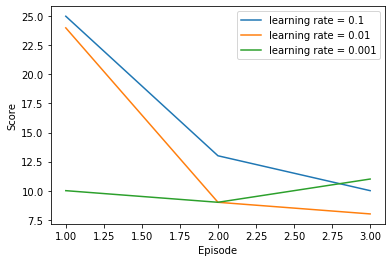

In [11]:
for i,lr in enumerate(learning_rates):
    plt.plot(np.arange(1,total_episodes+1), score_per_lr[i], label =f"learning rate = {lr}")
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend()